In [1]:
%%javascript

window.scroll_flag = true
window.scroll_exit = false
window.scroll_delay = 100

$(".output_scroll").each(function() {
    $(this)[0].scrollTop = $(this)[0].scrollHeight;
});

function callScrollToBottom() {
    setTimeout(scrollToBottom, window.scroll_delay);
}

function scrollToBottom() {
    if (window.scroll_exit) {
        return;
    }
    if (!window.scroll_flag) {
        callScrollToBottom();
        return;
    };
    
    $(".output_scroll").each(function() {
        if (!$(this).attr('scroll_checkbox')){
            window.scroll_flag = true;
            $(this).attr('scroll_checkbox',true);
            var div = document.createElement('div');
            var checkbox = document.createElement('input');
            checkbox.type = "checkbox";
            checkbox.onclick = function(){window.scroll_flag = checkbox.checked}
            checkbox.checked = "checked"
            div.append("Auto-Scroll-To-Bottom: ");
            div.append(checkbox);
            $(this).parent().before(div);
        }
        
        $(this)[0].scrollTop = $(this)[0].scrollHeight;
    });
    callScrollToBottom();
}
scrollToBottom();

<IPython.core.display.Javascript object>

In [2]:
import os
import IPython
import keras_tuner as kt
import librosa as lr
import numpy as np
from datetime import datetime
from packaging import version
import tensorboard
import keras
from keras import layers
from keras import regularizers
import tensorflow as tf
import matplotlib.pyplot as plt
from librosa import display
from tensorflow.keras.layers import Conv2D,MaxPooling2D,UpSampling2D,Flatten,Dense,Activation
from keras_tuner.tuners import RandomSearch
from keras_tuner.engine.hyperparameters import HyperParameters
import time

LOG_DIR = f'{int(time.time())}'

path = 'C:/Users/erikv/Desktop/IP/samples/' 
dirs = os.listdir(path)
#IPython.display.display(IPython.display.Audio(path+dirs[3],rate=sroriginal))

def rosaspec(sound, NFFT):
    sound = np.concatenate((np.zeros(int(NFFT/2)),sound,np.zeros(int(NFFT/2))))
    spec_c = lr.stft(sound, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    return np.concatenate((np.expand_dims(np.real(spec_c),2),np.expand_dims(np.imag(spec_c),2)),axis=2)

def irosaspec(spec,NFFT):
    spec_c = spec[:,:,0].squeeze() + 1j* spec[:,:,1].squeeze()
    return lr.istft(spec_c, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)[int(NFFT/2):-int(NFFT/2)]
#use a rectangular window.

In [3]:
NFFT = int(1021/2)
yoriginal1,sroriginal1 = lr.load(path+dirs[9],sr=2*8150)
originalspect = lr.stft(yoriginal1, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
asignal = np.array([rosaspec(yoriginal1,NFFT)])
test = asignal/asignal.max()

print (test.shape)

(1, 256, 256, 2)


In [4]:
batchsize = 100 #len(dirs)
processed = np.zeros([batchsize, 256, 256, 2])
for i in range(batchsize):
    yoriginal,sroriginal = lr.load(path+dirs[i],sr=2*8150)
    originalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    asignal = np.array([rosaspec(yoriginal,NFFT)])
    audio = asignal/asignal.max()
    processed[i] = audio

print (audio.shape,processed.shape)

(1, 256, 256, 2) (10, 256, 256, 2)


In [5]:
device = 'cuda'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(test[0,66,26,0])
print(processed[9,66,26,0])

Num GPUs Available:  1
3.904032647661956e-07
3.904032647661956e-07


In [42]:
input_shape = (processed.shape)
inp = (input_shape[1],input_shape[2],input_shape[3])

def build_model_tuned(x,a1,a2,a3,b1,b2,b3):
    model = keras.models.Sequential()
    
    model.add(Conv2D(x, (3,3), padding='same', input_shape=(inp)))
    model.add(Activation('LeakyReLU'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(a1,(3,3), padding='same'))
    model.add(Activation('LeakyReLU'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(a2,(3,3), padding='same'))
    model.add(Activation('LeakyReLU'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    model.add(Conv2D(a3,(3,3), padding='same'))
    model.add(Activation('LeakyReLU'))
    model.add(MaxPooling2D((2, 2), padding='same'))
    
    model.add(Conv2D(b1,(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(b2,(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(b3,(3,3),activation='LeakyReLU', padding='same'))
    model.add(UpSampling2D((2, 2)))
        
    model.add(UpSampling2D((2, 2)))
    model.add(Conv2D(2,(3,3),activation='LeakyReLU', padding='same'))
    model.compile(optimizer='adam', 
                  loss='mean_absolute_percentage_error',
                  metrics=['accuracy'])

    return model

In [44]:
n = 2
autoencoder = build_model_tuned(8,16,32,64,32,16,8)
print(autoencoder.summary())

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_60 (Conv2D)           (None, 256, 256, 8)       152       
_________________________________________________________________
activation_30 (Activation)   (None, 256, 256, 8)       0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 128, 128, 8)       0         
_________________________________________________________________
conv2d_61 (Conv2D)           (None, 128, 128, 16)      1168      
_________________________________________________________________
activation_31 (Activation)   (None, 128, 128, 16)      0         
_________________________________________________________________
max_pooling2d_31 (MaxPooling (None, 64, 64, 16)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 64, 64, 32)       

In [45]:
autoencoder.fit(processed,processed,
                epochs=100,
                batch_size=10,
                shuffle=True,
                validation_data=(test,test))

Epoch 1/100
1/1 [==============================] - 1s 1s/step - loss: 13799.0029 - accuracy: 0.4922 - val_loss: 283903.1875 - val_accuracy: 0.4441
Epoch 2/100
1/1 [==============================] - 0s 62ms/step - loss: 239300.7812 - accuracy: 0.4579 - val_loss: 470459.7812 - val_accuracy: 0.5548
Epoch 3/100
1/1 [==============================] - 0s 60ms/step - loss: 385163.5312 - accuracy: 0.5413 - val_loss: 90733.8750 - val_accuracy: 0.5341
Epoch 4/100
1/1 [==============================] - 0s 66ms/step - loss: 73701.7188 - accuracy: 0.5230 - val_loss: 110069.7969 - val_accuracy: 0.4441
Epoch 5/100
1/1 [==============================] - 0s 67ms/step - loss: 93186.7266 - accuracy: 0.4578 - val_loss: 168972.6875 - val_accuracy: 0.4441
Epoch 6/100
1/1 [==============================] - 0s 66ms/step - loss: 142262.7969 - accuracy: 0.4578 - val_loss: 182283.7500 - val_accuracy: 0.4441
Epoch 7/100
1/1 [==============================] - 0s 59ms/step - loss: 153686.5312 - accuracy: 0.4578 - v

Epoch 56/100
1/1 [==============================] - 0s 69ms/step - loss: 8901.4512 - accuracy: 0.4618 - val_loss: 11130.8477 - val_accuracy: 0.4498
Epoch 57/100
1/1 [==============================] - 0s 52ms/step - loss: 9703.5742 - accuracy: 0.4627 - val_loss: 9826.2246 - val_accuracy: 0.4962
Epoch 58/100
1/1 [==============================] - 0s 53ms/step - loss: 8617.1309 - accuracy: 0.4961 - val_loss: 10542.5977 - val_accuracy: 0.5465
Epoch 59/100
1/1 [==============================] - 0s 60ms/step - loss: 9178.8135 - accuracy: 0.5329 - val_loss: 26112.1504 - val_accuracy: 0.4487
Epoch 60/100
1/1 [==============================] - 0s 62ms/step - loss: 22129.5586 - accuracy: 0.4616 - val_loss: 11485.8379 - val_accuracy: 0.4488
Epoch 61/100
1/1 [==============================] - 0s 58ms/step - loss: 9990.2266 - accuracy: 0.4619 - val_loss: 11425.9648 - val_accuracy: 0.5465
Epoch 62/100
1/1 [==============================] - 0s 56ms/step - loss: 9939.2812 - accuracy: 0.5327 - val_loss

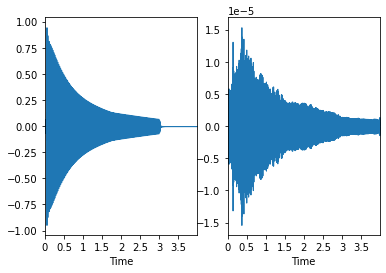

-5.752402936125017e-06
-0.000121487574


In [46]:
decoded_array = autoencoder.predict(processed)[9]
decoded_audio = irosaspec(decoded_array,NFFT)

enprobe = rosaspec(yoriginal1, NFFT)
deprobe = irosaspec(enprobe,NFFT)

#noisy = yoriginal+np.random.normal(0,0.01,64000)
#ennoisy = rosaspec(noisy, NFFT)
#denoisy = irosaspec(ennoisy,NFFT)

plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=decoded_audio,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal1,sr=sroriginal)
plt.show()

#IPython.display.display(IPython.display.Audio(file))
IPython.display.display(IPython.display.Audio(deprobe,rate = sroriginal))
#IPython.display.display(IPython.display.Audio(noisy,rate=sroriginal))
#IPython.display.display(IPython.display.Audio(denoisy,rate=sroriginal))
IPython.display.display(IPython.display.Audio(decoded_audio,rate=sroriginal))

print(test[0,66,26,1])
print(decoded_array[66,26,1])

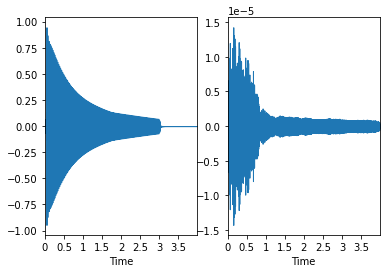

In [33]:
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y


# Setting standard filter requirements.
order = 6
fs = 30.0       
cutoff = 8

b, a = butter_lowpass(cutoff, fs, order)

filtered1 = butter_lowpass_filter(yoriginal1, cutoff, fs, order)
filtered = butter_lowpass_filter(decoded_audio, cutoff, fs, order)
plt.figure()
plt.subplot(1, 2, 2) 
lr.display.waveplot(y=filtered,sr=sroriginal)
plt.subplot(1, 2, 1) 
lr.display.waveplot(y=yoriginal1,sr=sroriginal)
plt.show()

IPython.display.display(IPython.display.Audio(yoriginal1,rate=sroriginal))
IPython.display.display(IPython.display.Audio(filtered,rate=sroriginal))

In [102]:
audio.max(), audio.min()

(1.0, -0.856759766190995)

In [89]:
print(yoriginal.shape)
print(enprobe.shape)
print(deprobe.shape)
print(decoded_array.shape)
print(decoded_audio.shape)



(64000,)
(504, 128, 2)
(63881,)
(504, 128, 2)
(63881,)


(1.0, -0.7587283885818327)

In [81]:
i = 2
j = 4
while i<25600/2:
    NFFT = i
    file = 'C:/Users/erikv/Desktop/IP/samples/bass_electronic_027-056-050.wav'

    yoriginal,sroriginal = lr.load(file,sr=None)
    orginalspect = lr.stft(yoriginal, n_fft=NFFT, hop_length=int(NFFT/2), win_length=None, window='hann', center=False)
    audio = np.array([rosaspec(yoriginal,NFFT)])

    numbers = audio.shape
    x = numbers[1]
    y = numbers[2]
    if x%j == 0 and y%j == 0:
            print (i)
    i=i+2

110
126
134
166
174
182
254
286
294
302
334
382
406
422
478
486
494
518
526
534
582
606
630
654
670
766
782
822
846
870
894
918
942
974
1006
1038
1070
1110
1150
1190
1238
1286
1334
1342
1398
1406
1462
1470
1526
1534
1542
1606
1614


KeyboardInterrupt: 

<IPython.core.display.Javascript object>